In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer

In [5]:
%cd C:\Users\wenyoudi\Documents\DSA3101\src

C:\Users\wenyoudi\Documents\DSA3101\src


In [6]:
df = pd.read_csv("../Data/digital_marketing_campaign_dataset.csv")
df.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1


## Identify KPIs based on EDA

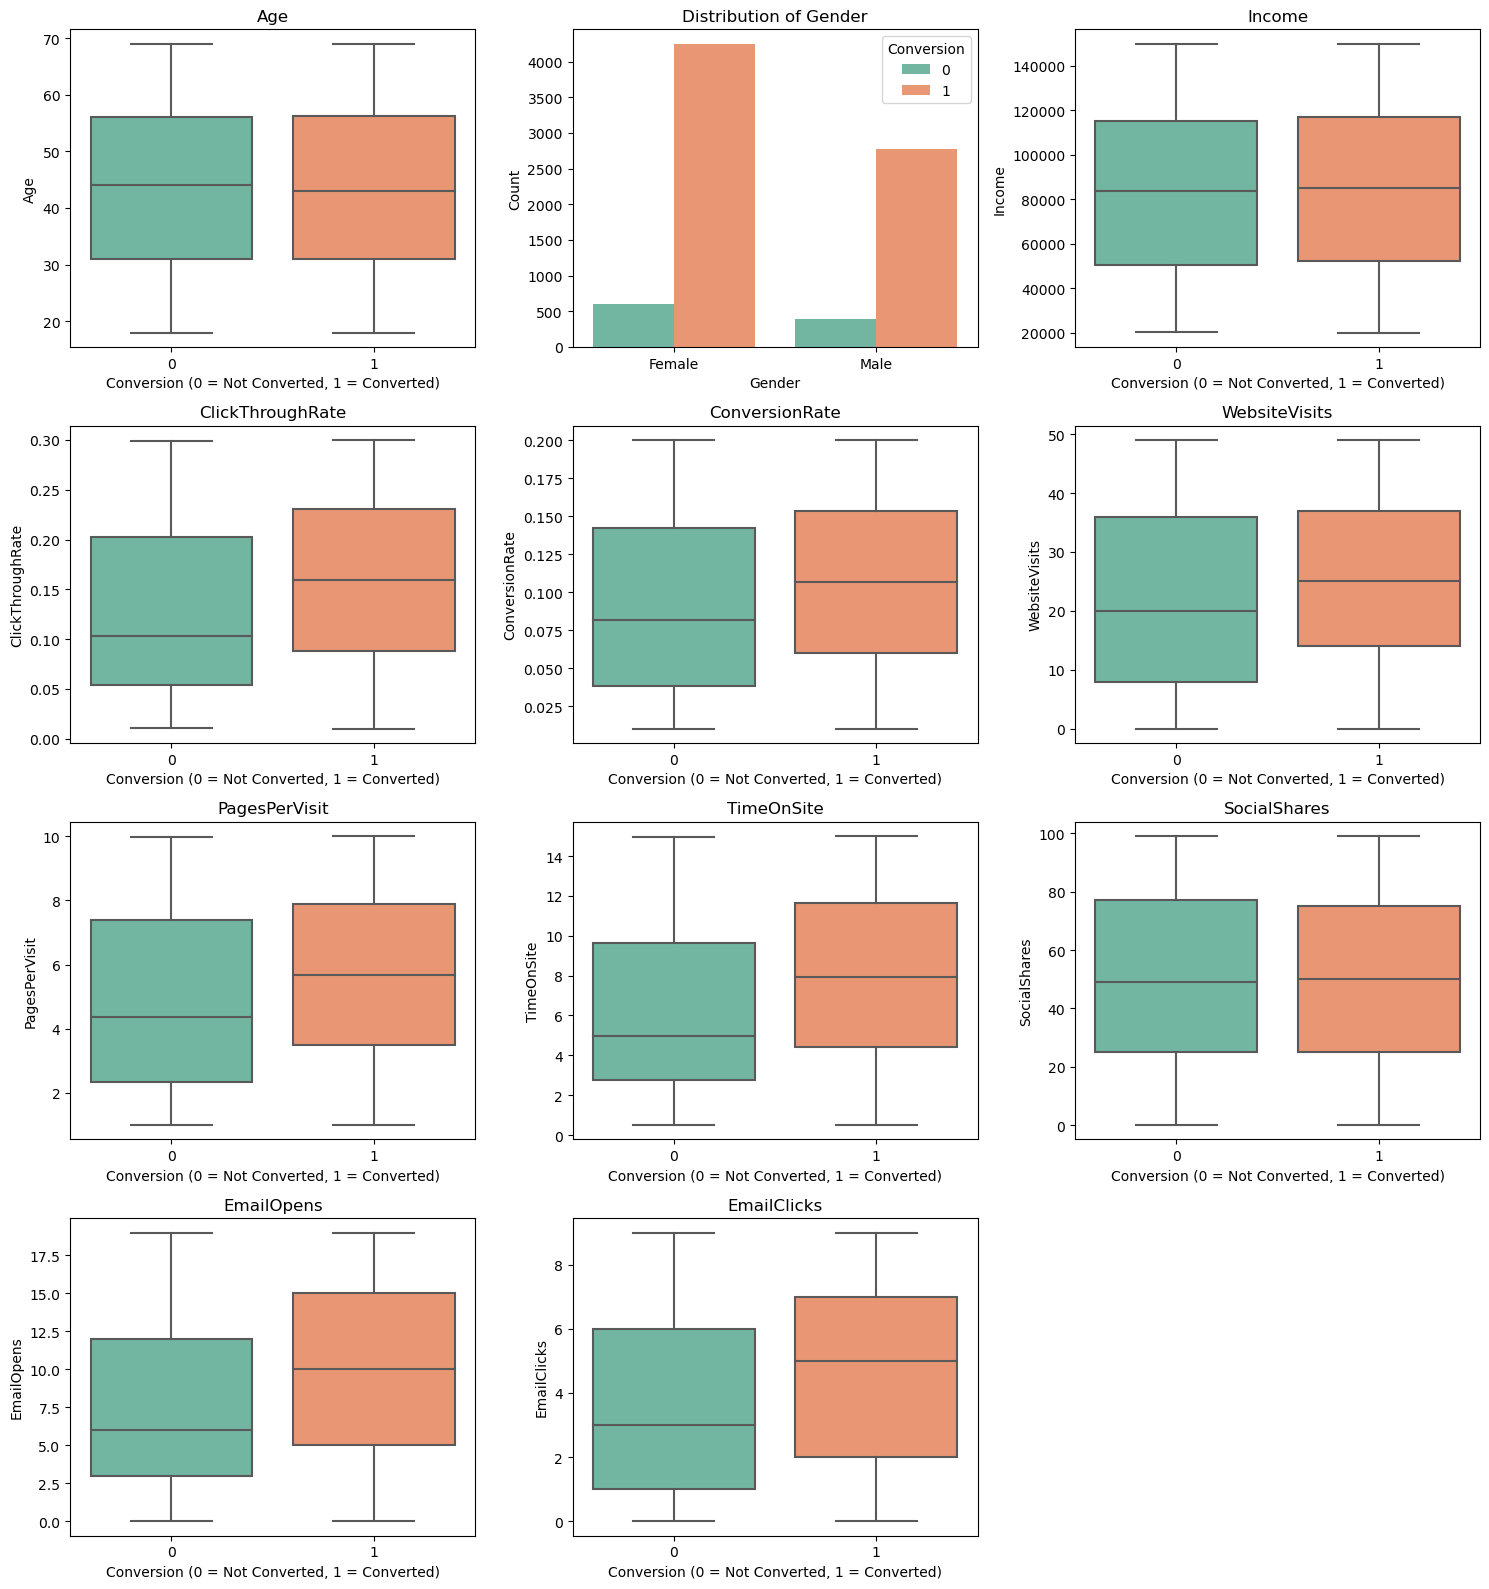

In [7]:
columns = ['Age', 'Gender', 'Income',
           'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 
           'PagesPerVisit', 'TimeOnSite', 'SocialShares', 
           'EmailOpens', 'EmailClicks']


num_vars = len(columns)
cols = 3  # number of plots per row
rows = int(np.ceil(num_vars / cols))

plt.figure(figsize=(5 * cols, 4 * rows))

for i, var in enumerate(columns, 1):
    plt.subplot(rows, cols, i)
    if var == 'Gender':
        sns.countplot(x=var, hue='Conversion', data=df, palette='Set2')
        plt.title(f'Distribution of {var}')
        plt.xlabel(var)
        plt.ylabel('Count')
    else:
        sns.boxplot(x='Conversion', y=var, data=df, palette='Set2')
        plt.title(var)
        plt.xlabel('Conversion (0 = Not Converted, 1 = Converted)')
        plt.ylabel(var)

plt.tight_layout()
plt.show()

**Age**  
   - The median age appears slightly higher for converters than for non-converters. Converters also show a somewhat wider spread, indicating that older demographics might be more likely to convert, though there is overlap between the two groups.

**Gender**  
   - The count plot shows more female than male customers overall. However, without proportions, it’s not immediately clear if one gender has a distinctly higher conversion rate. You could compute the percentage of females vs. males who convert to see if there’s a meaningful difference.

**Income**  
   - The median income for converters is marginally higher than for non-converters, suggesting that higher-income customers might be slightly more inclined to convert. The difference doesn’t appear as pronounced as for some other variables, but there is a small shift in the median.

**ClickThroughRate**  
   - Converters tend to have a higher click-through rate, indicating stronger engagement with marketing content. The boxplot suggests that the bulk of converters consistently click more frequently than non-converters.

**ConversionRate**  
   - The plot shows that those who ultimately convert show higher engagement levels leading up to conversion.

**WebsiteVisits**  
   - The median and interquartile range for website visits are higher for converters, implying that more frequent site visits are associated with a greater likelihood of conversion.

**PagesPerVisit**  
   - Converters view more pages per session on average. This deeper on-site engagement may reflect stronger interest or better targeting by the marketing campaign.

**TimeOnSite**  
   - Converters spend more time on the site, further supporting the idea that sustained engagement correlates with conversion.

**SocialShares**  
   - There is no strong visible difference in social shares between converters and non-converters. The medians are fairly similar, suggesting this KPI may not be a strong predictor of conversion in this dataset.

**EmailOpens**  
- Converters have higher email-open activity, indicating that they are more responsive to email campaigns.

**EmailClicks**  
- Similarly, converters click more frequently in emails. This higher level of interaction is a strong indicator that email engagement is tied to eventual conversion.

### Overall Takeaways

- **Engagement Metrics Matter:** Variables like ClickThroughRate, ConversionRate, WebsiteVisits, PagesPerVisit, TimeOnSite, EmailOpens, and EmailClicks all show notably higher medians for converters, suggesting that deeper and more frequent engagement strongly correlates with conversion.
- **Demographic & Financial Indicators:** Slightly higher Age and Income among converters could hint at demographic factors, but the difference is not as stark as with engagement metrics.
- **Gender Distribution:** Although more females are present in the dataset, it’s not immediately clear if that translates into a higher conversion rate without additional percentage-based analysis.
- **Potential Non-Factor:** SocialShares does not exhibit a clear difference between converters and non-converters, suggesting it may not be a strong predictor of conversion in this context.

In [10]:
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency, fisher_exact

df_converted = df[df['Conversion'] == 1]
df_nonconverted = df[df['Conversion'] == 0]

numeric_vars = ['Age', 'Income', 'ClickThroughRate', 'ConversionRate', 
                'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 
                'SocialShares', 'EmailOpens', 'EmailClicks']

print("Numeric Variables Hypothesis Testing:\n")

for var in numeric_vars:
    conv_data = df_converted[var].dropna()
    nonconv_data = df_nonconverted[var].dropna()

    # Two-sample t-test
    t_stat, p_val_t = ttest_ind(conv_data, nonconv_data, equal_var=False)

    # Mann-Whitney U test
    u_stat, p_val_u = mannwhitneyu(conv_data, nonconv_data, alternative='two-sided')

    print(f"KPI: {var}")
    print(f"  T-test: t-stat = {t_stat:.3f}, p-value = {p_val_t:.6f}")
    print(f"  Mann-Whitney U: U-stat = {u_stat:.3f}, p-value = {p_val_u:.6f}\n")

print("\nCategorical Variable (Gender) Hypothesis Testing:\n")

contingency_table = pd.crosstab(df['Gender'], df['Conversion'])
print("Contingency Table (Gender vs. Conversion):\n", contingency_table, "\n")

chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square Test: chi2 = {chi2:.3f}, p-value = {p_chi2:.6f}, dof = {dof}")
print("Expected counts:\n", expected, "\n")

Numeric Variables Hypothesis Testing:

KPI: Age
  T-test: t-stat = 0.142, p-value = 0.887455
  Mann-Whitney U: U-stat = 3473939.000, p-value = 0.882881

KPI: Income
  T-test: t-stat = 1.242, p-value = 0.214488
  Mann-Whitney U: U-stat = 3549044.000, p-value = 0.210440

KPI: ClickThroughRate
  T-test: t-stat = 10.646, p-value = 0.000000
  Mann-Whitney U: U-stat = 4195660.000, p-value = 0.000000

KPI: ConversionRate
  T-test: t-stat = 7.904, p-value = 0.000000
  Mann-Whitney U: U-stat = 4034273.000, p-value = 0.000000

KPI: WebsiteVisits
  T-test: t-stat = 6.672, p-value = 0.000000
  Mann-Whitney U: U-stat = 3941646.000, p-value = 0.000000

KPI: PagesPerVisit
  T-test: t-stat = 8.695, p-value = 0.000000
  Mann-Whitney U: U-stat = 4089538.000, p-value = 0.000000

KPI: TimeOnSite
  T-test: t-stat = 11.605, p-value = 0.000000
  Mann-Whitney U: U-stat = 4253146.000, p-value = 0.000000

KPI: SocialShares
  T-test: t-stat = -1.017, p-value = 0.309341
  Mann-Whitney U: U-stat = 3394042.000, p-v

Based on the hypothesis testing results:

- **Age and Income:**  
  Both the t-test and Mann-Whitney U tests for Age and Income have very high p-values (around 0.88 for Age and 0.21 for Income), which indicates no significant difference between converters and non-converters. This suggests that neither age nor income is a strong differentiator for conversion in this dataset.

- **Engagement Metrics (ClickThroughRate, ConversionRate, WebsiteVisits, PagesPerVisit, TimeOnSite, EmailOpens, EmailClicks):**  
  These metrics all yield extremely low p-values (p < 0.001) in both tests, showing highly significant differences between the two groups. Converters tend to have higher engagement levels (more clicks, website visits, longer time on site, etc.), implying these variables are strong indicators of conversion.

- **SocialShares:**  
  With p-values around 0.31, SocialShares does not differ significantly between converters and non-converters. This suggests that social sharing, in this dataset, may not be a useful predictor of conversion.

- **Gender (Categorical Variable):**  
  The contingency table for Gender versus Conversion shows similar expected and observed counts, and the Chi-square test results (chi2 ≈ 0.004, p ≈ 0.951) indicate no significant association between gender and conversion. This implies that conversion rates are statistically similar between females and males.

Overall, the analysis suggests that engagement metrics (except SocialShares) are strongly associated with conversion, whereas demographic factors like age, income, and gender are not significant differentiators in this context.

In [11]:
kpi_columns = ['ClickThroughRate', 'ConversionRate',
               'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite',
               'EmailOpens', 'EmailClicks']

In [9]:
df_converted = df[df['Conversion'] == 1]
df_nonconverted = df[df['Conversion'] == 0]

print("Number of converters:", len(df_converted))
print("Number of non-converters:", len(df_nonconverted))

Number of converters: 7012
Number of non-converters: 988


In [12]:
stats_converted = df_converted[kpi_columns].agg(['mean', 'median', 'std'])
stats_nonconverted = df_nonconverted[kpi_columns].agg(['mean', 'median', 'std'])

print("\nDescriptive Statistics for Converters:")
print(stats_converted)

print("\nDescriptive Statistics for Non-Converters:")
print(stats_nonconverted)


Descriptive Statistics for Converters:
        ClickThroughRate  ConversionRate  WebsiteVisits  PagesPerVisit  \
mean            0.158613        0.106308      25.177838       5.649945   
median          0.159202        0.106523      25.000000       5.673386   
std             0.083192        0.054097      14.105787       2.565746   

        TimeOnSite  EmailOpens  EmailClicks  
mean      7.933413    9.744581     4.606246  
median    7.921671   10.000000     5.000000  
std       4.187767    5.650668     2.829280  

Descriptive Statistics for Non-Converters:
        ClickThroughRate  ConversionRate  WebsiteVisits  PagesPerVisit  \
mean            0.127972        0.090766      21.726721       4.835002   
median          0.103357        0.081513      20.000000       4.371865   
std             0.084904        0.058373      15.371397       2.784168   

        TimeOnSite  EmailOpens  EmailClicks  
mean      6.267871    7.576923     3.481781  
median    4.966760    6.000000     3.000000  


## KPI threshold selection

In [14]:
from sklearn.metrics import roc_curve, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Conversion'])

results = {}

for kpi in kpi_columns:
    y_true_train = train_df['Conversion'].values
    scores_train = train_df[kpi].values
    
    fpr, tpr, thresholds = roc_curve(y_true_train, scores_train)
    
    J = tpr - fpr
    best_index = np.argmax(J)
    best_threshold = thresholds[best_index]
    
    y_true_test = test_df['Conversion'].values
    scores_test = test_df[kpi].values
    y_pred_test = (scores_test >= best_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true_test, y_pred_test).ravel()
    
    sensitivity_test = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity_test = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    f1 = f1_score(y_true_test, y_pred_test)
    
    results[kpi] = {
        "Best Threshold (Train)": best_threshold,
        "Test Sensitivity": sensitivity_test,
        "Test Specificity": specificity_test,
        "Test F1 Score": f1,
        "Youden's J (Train)": J[best_index]
    }
results_df = pd.DataFrame.from_dict(results, orient='index')
print("Summary of Threshold Selection and Test Evaluation Results:")
print(results_df)

Summary of Threshold Selection and Test Evaluation Results:
                  Best Threshold (Train)  Test Sensitivity  Test Specificity  \
ClickThroughRate                0.097254          0.718631          0.432432   
ConversionRate                  0.049689          0.817015          0.337838   
WebsiteVisits                  11.000000          0.810361          0.358108   
PagesPerVisit                   2.981618          0.817015          0.307432   
TimeOnSite                      4.989053          0.720057          0.472973   
EmailOpens                      6.000000          0.744772          0.486486   
EmailClicks                     3.000000          0.725760          0.469595   

                  Test F1 Score  Youden's J (Train)  
ClickThroughRate       0.799154            0.225384  
ConversionRate         0.855437            0.186681  
WebsiteVisits          0.852713            0.157334  
PagesPerVisit          0.853525            0.229015  
TimeOnSite             0.8026

## Logistic Regression for weightage of KPI

In [15]:
from sklearn.metrics import roc_curve, confusion_matrix, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Conversion'])

X_train = train_df[kpi_columns].fillna(0)
y_train = train_df['Conversion']
X_test  = test_df[kpi_columns].fillna(0)
y_test  = test_df['Conversion']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

y_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

J = tpr - fpr
best_index = np.argmax(J)
best_prob_threshold = thresholds[best_index]

print("Optimal Conversion Probability Threshold:", best_prob_threshold)
print("Youden's J at Optimal Threshold:", J[best_index])

y_pred = (y_prob >= best_prob_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nEvaluation on Test Set:")
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("F1 Score:", f1)
print("ROC-AUC:", auc)

Optimal Conversion Probability Threshold: 0.8509985118330468
Youden's J at Optimal Threshold: 0.3552692426266571

Evaluation on Test Set:
Sensitivity: 0.7775665399239544
Specificity: 0.5777027027027027
F1 Score: 0.8465717981888745
ROC-AUC: 0.7139393433357313


## Calculate score

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = df[kpi_columns].fillna(0)

# Standardize the features using the same scaler (fitted on training data)
X_scaled = scaler.transform(X)

# Retrieve logistic regression coefficients and intercept
coefficients = lr_model.coef_[0]   # array of weights for each KPI
intercept = lr_model.intercept_[0]   # model intercept

# Calculate the engagement score as a weighted sum (log-odds)
df['engagement_score'] = np.dot(X_scaled, coefficients) + intercept

# Scale the engagement score to a range of 0 to 10 using MinMaxScaler
scaler_engagement = MinMaxScaler(feature_range=(0, 10))
df['scaled_engagement_score'] = scaler_engagement.fit_transform(df[['engagement_score']])

print("\nScaled Engagement Scores (first 5 rows):")
print(df[['engagement_score', 'scaled_engagement_score']].head())



Scaled Engagement Scores (first 5 rows):
   engagement_score  scaled_engagement_score
0          1.166779                 3.189887
1          2.481053                 5.059101
2          3.236180                 6.133073
3          2.385539                 4.923256
4          2.717087                 5.394799


## Compare score with #KPIs met

In [18]:
kpi_thresholds = {
    'ClickThroughRate': 0.097254,
    'ConversionRate': 0.049689,
    'WebsiteVisits': 11.0,
    'PagesPerVisit': 2.981618,
    'TimeOnSite': 4.989053,
    'EmailOpens': 6.0,
    'EmailClicks': 3.0
}

# Create a new column for each KPI indicating whether its threshold is met (1) or not (0)
for kpi, threshold in kpi_thresholds.items():
    df[kpi + '_met'] = (df[kpi] >= threshold).astype(int)

# Sum the "met" columns to obtain a KPI hit count for each observation
met_columns = [kpi + '_met' for kpi in kpi_thresholds.keys()]
df['KPI_hit_count'] = df[met_columns].sum(axis=1)

# Optionally, display the first few rows to see the hit counts alongside the original KPI values
print(df[['KPI_hit_count'] + list(kpi_thresholds.keys())].head())

   KPI_hit_count  ClickThroughRate  ConversionRate  WebsiteVisits  \
0              4          0.043919        0.088031              0   
1              5          0.155725        0.182725             42   
2              5          0.277490        0.076423              2   
3              5          0.137611        0.088004             47   
4              5          0.252851        0.109940              0   

   PagesPerVisit  TimeOnSite  EmailOpens  EmailClicks  
0       2.399017    7.396803           6            9  
1       2.917138    5.352549           2            7  
2       8.223619   13.794901          11            2  
3       4.540939   14.688363           2            2  
4       2.046847   13.993370           6            6  


Correlation between KPI Hit Count and Scaled Engagement Score:
                         KPI_hit_count  scaled_engagement_score
KPI_hit_count                 1.000000                 0.756292
scaled_engagement_score       0.756292                 1.000000


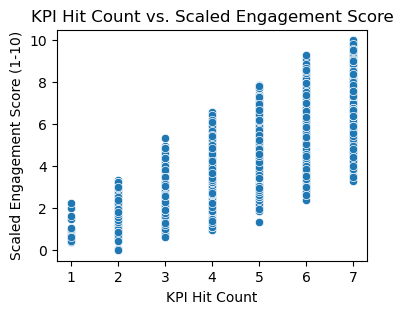

In [19]:
correlation = df[['KPI_hit_count', 'scaled_engagement_score']].corr()
print("Correlation between KPI Hit Count and Scaled Engagement Score:")
print(correlation)

plt.figure(figsize=(4, 3))
sns.scatterplot(x='KPI_hit_count', y='scaled_engagement_score', data=df)
plt.title("KPI Hit Count vs. Scaled Engagement Score")
plt.xlabel("KPI Hit Count")
plt.ylabel("Scaled Engagement Score (1-10)")
plt.show()